In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import lightgbm as lgb

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
apartments = pd.read_csv('resources/data/apartments_train.csv')
buildings = pd.read_csv('resources/data/buildings_train.csv')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)

apartments_test = pd.read_csv('resources/data/apartments_test.csv')
buildings_test = pd.read_csv('resources/data/buildings_test.csv')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)

In [4]:
data.price

0         7139520.0
1        10500000.0
2         9019650.0
3        10500000.0
4        13900000.0
            ...    
23280    13300000.0
23281    15854300.0
23282    19800000.0
23283    29999000.0
23284    10950000.0
Name: price, Length: 23285, dtype: float64

# Missing values 
We plot an overview of the missing values for the train- and test set.

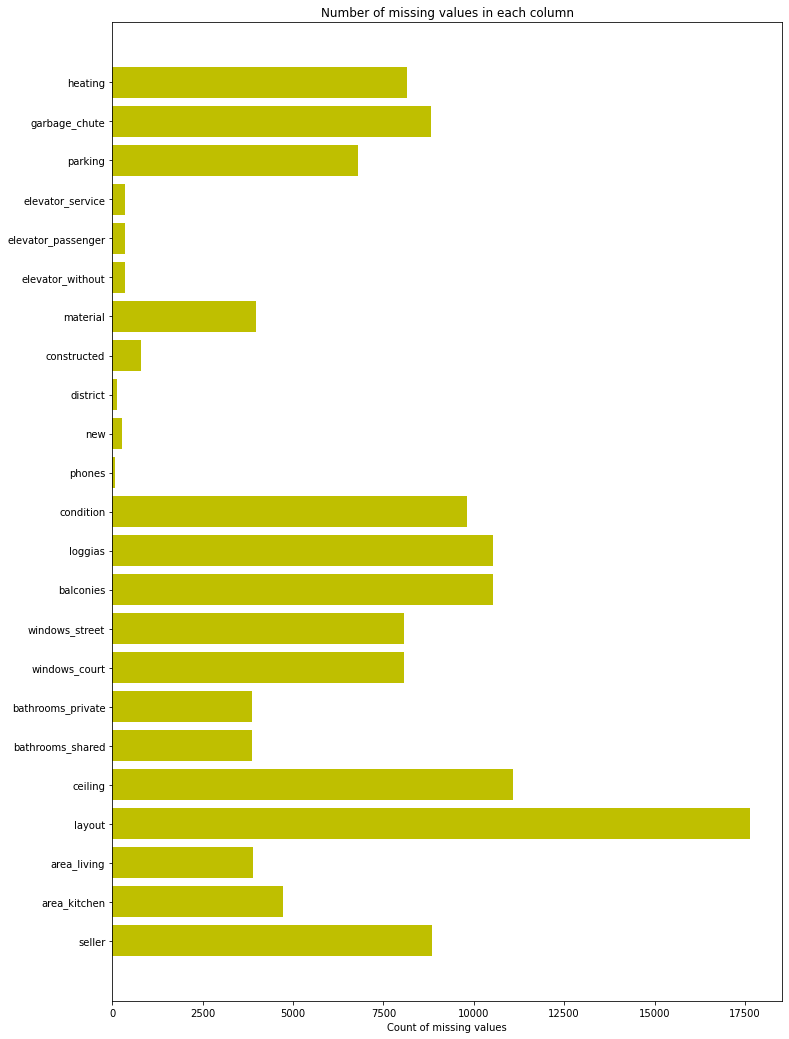

In [5]:
missing_df = data.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column in train set.")
plt.show()

Text(0.5, 1.0, 'Number of missing values in each column')

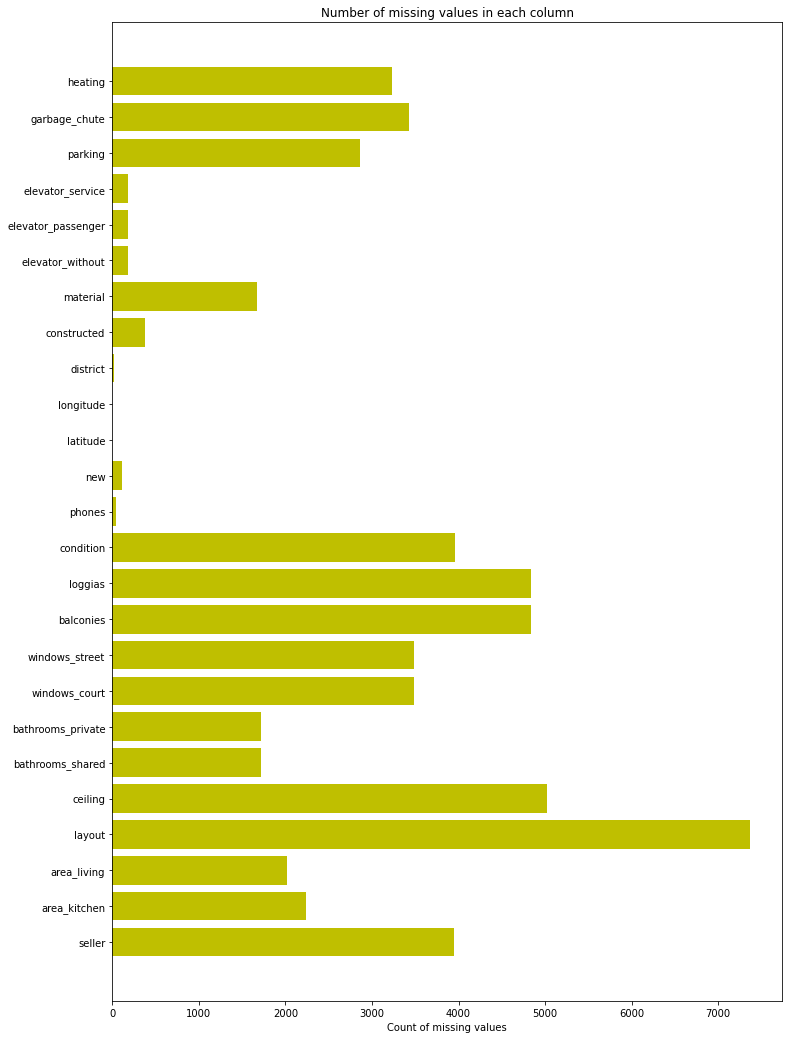

In [6]:
missing_df = data_test.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column in test set.")

We observe that some data seems to be missing in gropus. Foe example, the features relate to `windows` seem to either be missing or not (at the same time). This can easily be checked: `balconies` and `loggias`, 

In [11]:
data.loc[ ~data.windows_court.isna(), 'windows_street'].isna().any()

False

The same goes for `balconies`and `loggias`, the features related to `elevator` and the features related to `bathroom`.

# Distribution of categories between train- and test set

<AxesSubplot:xlabel='floor', ylabel='Count'>

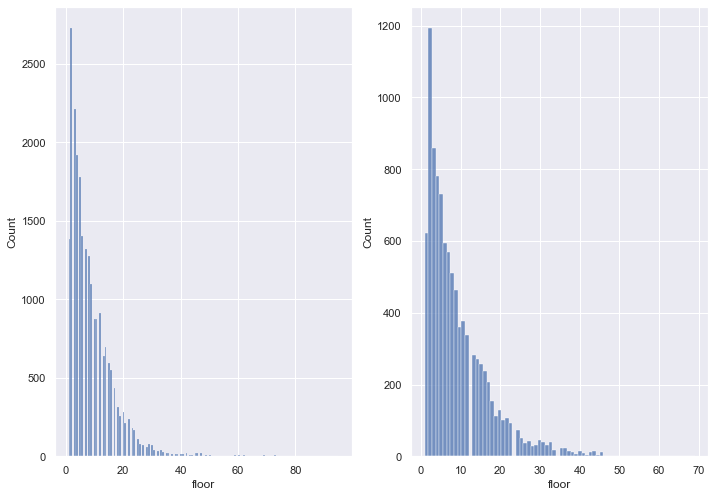

In [15]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig, ax =plt.subplots(1,2)
sns.histplot(data.floor, ax = ax[0])
sns.histplot(data_test.floor, ax = ax[1])

<AxesSubplot:xlabel='material', ylabel='Count'>

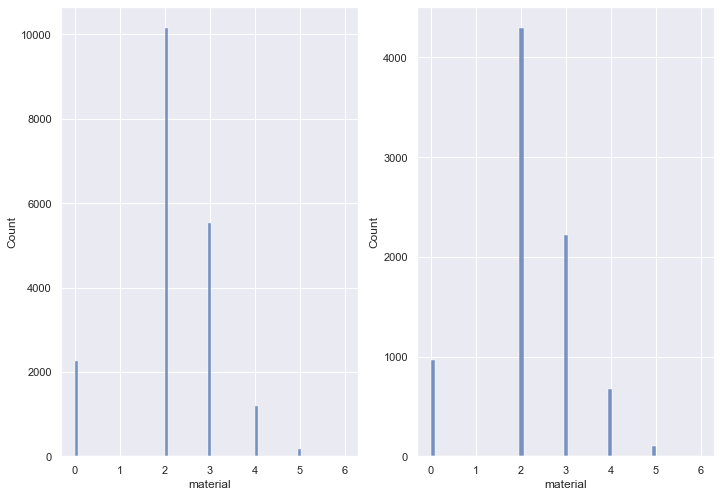

In [16]:
fig, ax =plt.subplots(1,2)
sns.histplot(data.material, ax = ax[0])
sns.histplot(data_test.material, ax = ax[1])

[Text(0.5, 0, ' condition (test)')]

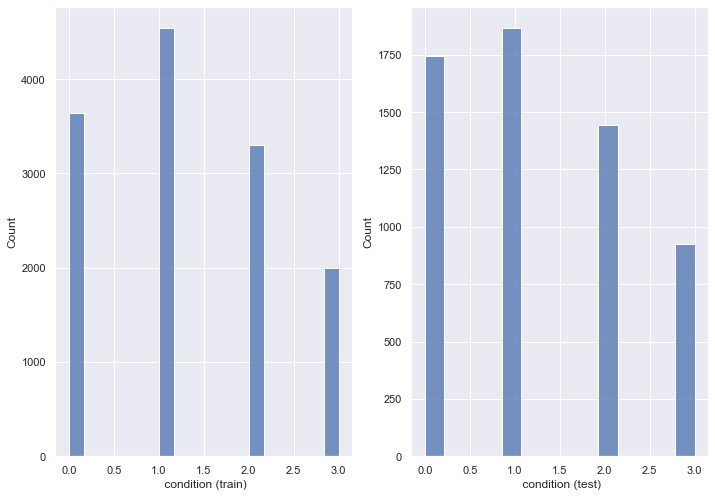

In [24]:
fig, ax =plt.subplots(1,2)
sns.histplot(data.condition, ax = ax[0])
sns.histplot(data_test.condition, ax = ax[1])
ax[0].set(xlabel = ' condition (train)')
ax[1].set(xlabel = ' condition (test)')

<AxesSubplot:xlabel='new', ylabel='Count'>

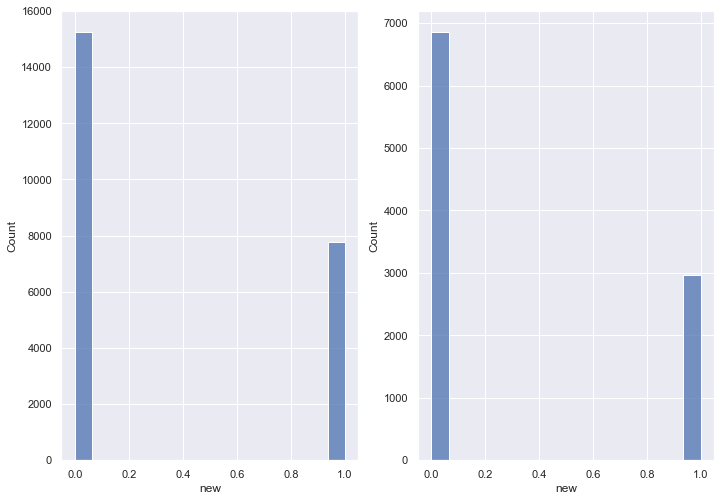

In [26]:
fig, ax =plt.subplots(1,2)
sns.histplot(data.new, ax = ax[0])
sns.histplot(data_test.new, ax = ax[1])

<AxesSubplot:xlabel='parking', ylabel='Count'>

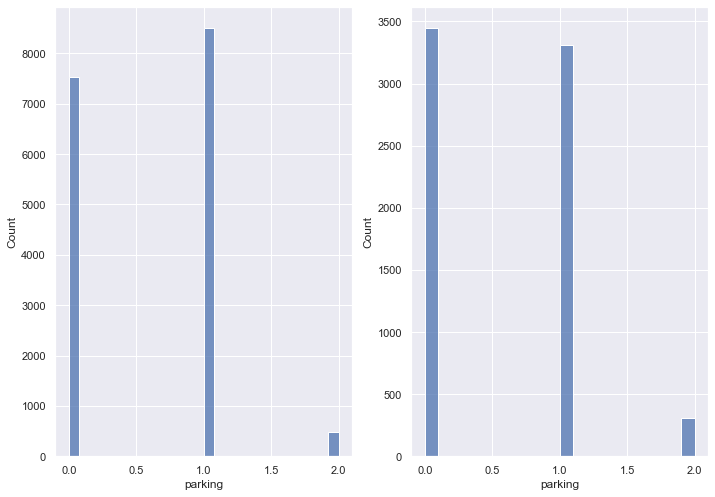

In [28]:
fig, ax =plt.subplots(1,2)
sns.histplot(data.parking, ax = ax[0])
sns.histplot(data_test.parking, ax = ax[1])

<AxesSubplot:xlabel='heating', ylabel='Count'>

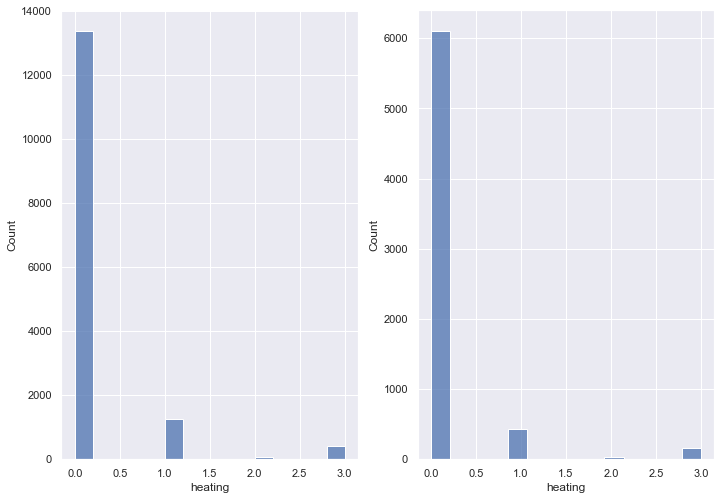

In [30]:
fig, ax =plt.subplots(1,2)
sns.histplot(data.heating,  ax = ax[0])
sns.histplot(data_test.heating, ax = ax[1])

<AxesSubplot:xlabel='layout', ylabel='Count'>

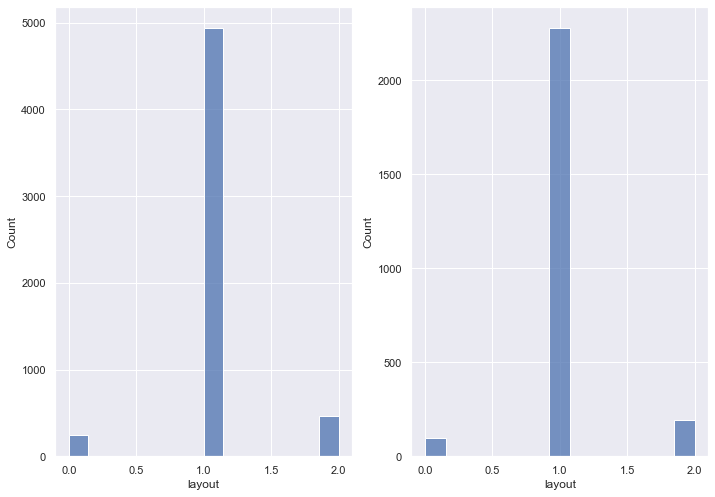

In [36]:
fig, ax =plt.subplots(1,2)
sns.histplot(data.layout, ax = ax[0])
sns.histplot(data_test.layout, ax = ax[1])


<AxesSubplot:xlabel='district', ylabel='Count'>

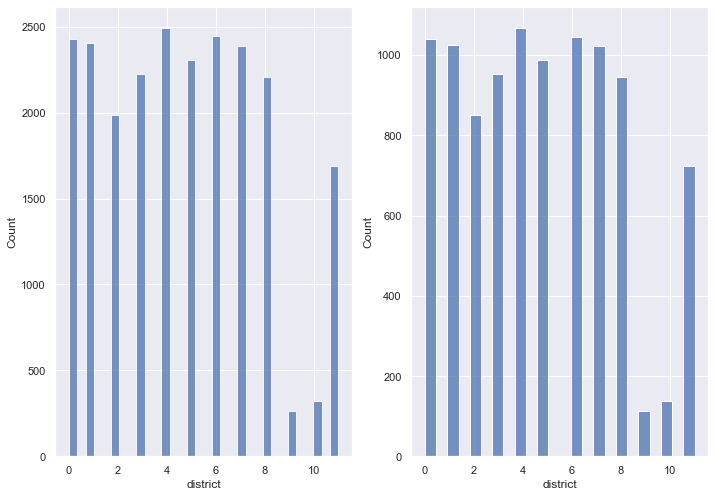

In [38]:
fig, ax =plt.subplots(1,2)
sns.histplot(data.district, ax = ax[0])
sns.histplot(data_test.district, ax = ax[1])

<AxesSubplot:xlabel='area_kitchen', ylabel='Count'>

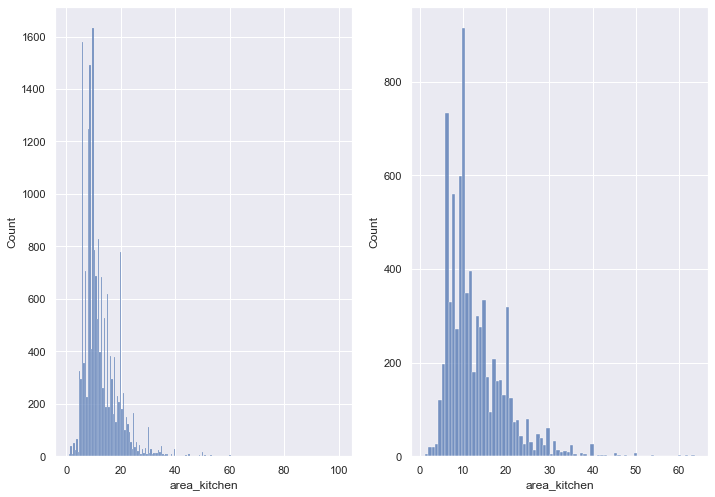

In [53]:
fig, ax =plt.subplots(1,2)
sns.histplot(data.area_kitchen, ax = ax[0])
sns.histplot(data_test.area_kitchen, ax = ax[1])

# Outliers

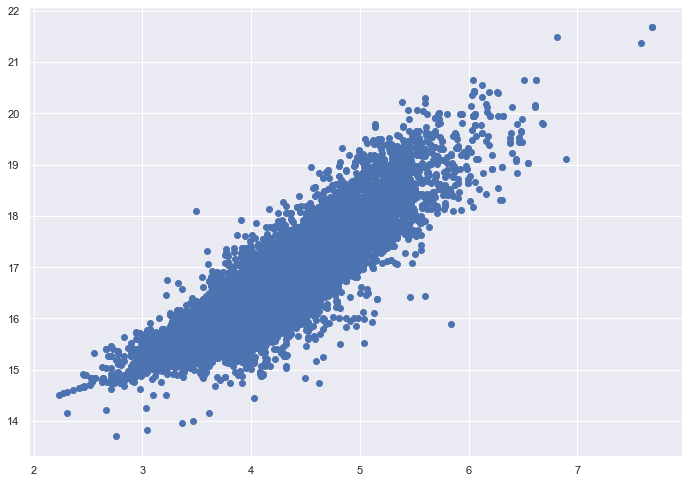

In [51]:
plt.scatter(np.log(data.area_total), np.log(data.price))

In [48]:
data.loc[data.area_total > 1000]

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
3217,3217,NaN,2.600000e+09,2181.0,NaN,NaN,95.0,6.0,NaN,NaN,...,12,2011.0,2.0,95.0,1.0,1.0,1.0,0.0,1.0,0.0
13938,13938,NaN,1.900000e+09,1971.0,NaN,NaN,51.0,6.0,NaN,NaN,...,8,2011.0,2.0,53.0,1.0,1.0,1.0,0.0,1.0,0.0
21414,21414,NaN,2.600000e+09,2181.0,NaN,NaN,95.0,1.0,NaN,3.5,...,12,2011.0,2.0,95.0,1.0,1.0,1.0,0.0,1.0,0.0
